## 調整後の株価をSQLiteに格納

筆者は、「シュミレーション~準備その１~」で説明した生の四本値と出来高を格納する SQLite(raw_prices.sqlite)ファイルのほかに、全く同じテーブルを持つ調整後の四本値と出来高を格納するSQLite(prices.sqlite)ファイル を作成しています。

prices.sqliteファイル の内容は、raw_prices.sqliteファイル の内容と株式分割・併合がなければ同一ですが、分割・併合が行われるたびにdivide_union_dataテーブルをもとに内容の更新を行います。

```
CREATE TABLE `t1605` (
    `id`    INTEGER, ---- 1983/1/1 を 0 としたDateまでの日数
    `Date`    TEXT,
    `Open`    REAL,
    `Hight`    REAL,
    `Low`    REAL,
    `Close`    REAL,
    `Volume`    INTEGER,
    PRIMARY KEY(`id`)
);
```

まず**divide_union_data**テーブルのレコードの中で**applied_divide_union_data** に登録がない分割・併合データーを取り出します。

そして、それぞれの分割・併合データーの分 割・併合割合を**prices.sqlite**ファイル内の権利確定日前のデーターに適用します。

四本値にかける係数 と、出来高に掛ける係数は逆数の関係にあるので注意が必要です。

例えば1:10の分割が行われた 場合、権利確定日以前の四本値の値は10分の1にしますが出来高は10倍にします。

 

この処理は以下のようなコードになるでしょう。

In [ ]:
import csv
import glob
import datetime
import os
import sqlite3
import requests
import glob


def set_price(dbpath, csv_path):
    
    # データベース接続とカーソル生成
    connection = sqlite3.connect(dbpath)
    # 自動コミットにする場合は下記を指定（コメントアウトを解除のこと）
    # connection.isolation_level = None
    cursor = connection.cursor()

    # 対象銘柄を格納したファイル
    f1 = glob.glob(os.path.join(csv_path, "*.csv"))

    i = 0

    baseDate = datetime.datetime.strptime('1983/1/1', "%Y/%m/%d")
    max_id = (datetime.datetime.now() - baseDate).days

    for path in f1:
        file_name = os.path.basename(path)
        code = file_name.split('.')[0]

        if not os.path.exists(path):
            continue

        # 株式分割・統合情報を取得
        sql = """
            SELECT
                d.code, d.date_of_right_allotment, d.before, d.after
            FROM
                divide_union_data AS d
            WHERE
                d.code = {} 
        """.format(code)

        divide_union_data = cursor.execute(sql)

        sample_list = {}
        for code, date_of_right_allotment, before, after in divide_union_data:

            rate =  after / before
            inv_rate = 1 / rate

            tdatetime = datetime.datetime.strptime(date_of_right_allotment, '%Y-%m-%d')
            id_of_right_allotment = (tdatetime - baseDate).days

            sample_list[id_of_right_allotment] = {'rate': rate, "inv_rate": inv_rate }


        # データベースの作成
        # CREATE
        cursor.execute("DROP TABLE IF EXISTS t{}".format(code))
        cursor.execute(
            "CREATE TABLE IF NOT EXISTS t{} (id INTEGER PRIMARY KEY, Date TEXT, Open REAL, High REAL, Low REAL, Close REAL, Volume INTEGER)"
            .format(code))

        # エラー処理（例外処理）
        try:

            csv_file = open(path, "r", encoding="ms932", errors="", newline="")
            f2 = csv.DictReader(csv_file, delimiter=",", doublequote=True,
                       lineterminator="\r\n", quotechar='"', skipinitialspace=True)

            counter = 0
            startDate = ""
            endDate = ""

            for line in f2:
                strDate = line["Date"]
                tmpDate = datetime.datetime.strptime(strDate, "%Y/%m/%d")

                # 値を用意
                id = (tmpDate - baseDate).days

                # 株式分割・統合情報 から換算係数を算出
                if(counter == 0 ):
                    rate = 1
                    inv_rate = 1
                    for i in sample_list:
                        rate *= sample_list[i]["rate"]
                        inv_rate *= sample_list[i]["inv_rate"]
                    if(len(sample_list)):
                        key_id = min(sample_list)
                    else:
                        key_id = max_id
                elif(id >= key_id):
                    rate = 1
                    inv_rate = 1
                    key_id = max_id
                    for i in sample_list:
                        if id < i:
                            key_id = min(key_id, i)
                            rate *= sample_list[i]["rate"]
                            inv_rate *= sample_list[i]["inv_rate"]


                Date = strDate
                Open = float(line["Open"])
                High= float(line["Hight"])
                Low = float(line["Low"])
                Close = float(line["Close"])
                Volume = int(line["Volume"])

                # INSERT
                sql = "INSERT INTO t{} VALUES ({}, '{}', {}, {} ,{}, {}, {})".format(code, id, Date, Open*rate, High*rate, Low*rate, Close*rate, Volume*inv_rate)

                cursor.execute(sql)

                #for log
                if len(startDate) == 0:
                    startDate = Date
                endDate = Date0
                counter += 1
 
            # 保存を実行（忘れると保存されないので注意）
            connection.commit()

            # print log
            print("{} について - > {} ～ {} まで {} 行の Table が出来ました"
                  .format(code, startDate, endDate, counter ))


        except sqlite3.Error as e:
            print('sqlite3.Error occurred:', e.args[0])
            connection.commit()
 
    # 接続を閉じる
    connection.close()



if __name__ == "__main__":
    set_price("prices.sqlite", "../data/")

### 換算した結果
2010年5月27日 に 1株を300株とする株式分割 を行った DeNa の株価は

もともと

In [1]:
connection = sqlite3.connect("raw_prices.sqlite")
dd = pd.read_sql("SELECT * FROM t{}".format(2432), connection, index_col='Date', parse_dates=True)
df = dd["2010/05/01":"2010/07/01"]
print(df)

NameError: name 'sqlite3' is not defined

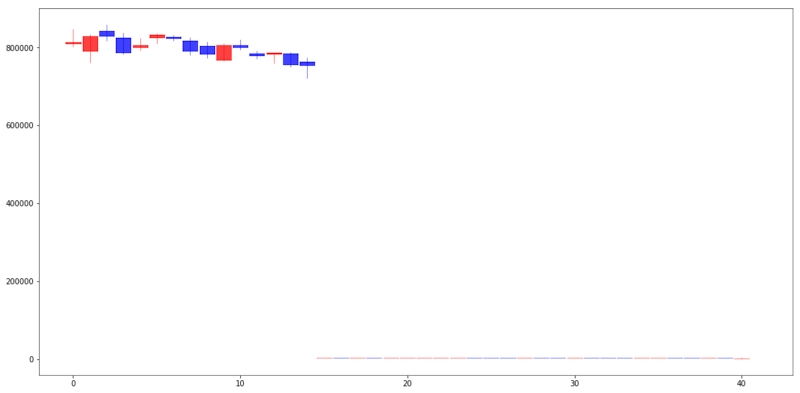

こうだった株価を換算し

In [2]:
connection = sqlite3.connect("prices.sqlite")
dd = pd.read_sql("SELECT * FROM t{}".format(2432), connection, index_col='Date', parse_dates=True)
df = dd["2010/05/01":"2010/07/01"]
print(df)

NameError: name 'sqlite3' is not defined

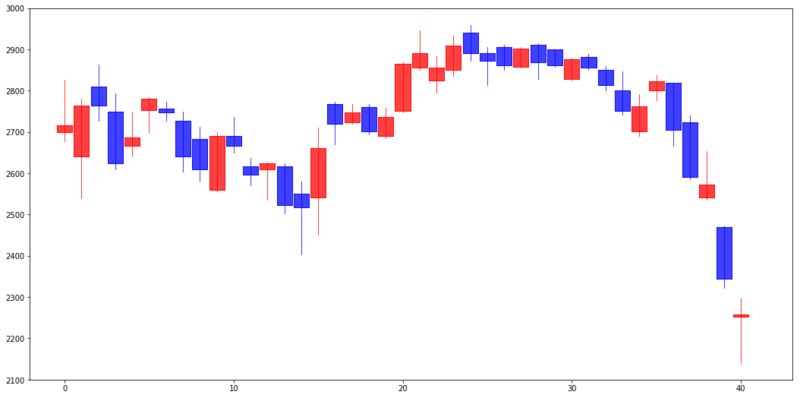

このように 現在の価値を基準に換算しました、このデータをシュミレーションに使用します。